In [33]:
import numpy as np

def IteratedLocalSearch(initial_solution, parallel, slv):
    solution = np.array(list(map(np.array, initial_solution)))
    old_cost = slv.solution_cost(solution)
    solution = LocalSearch(solution, is_feasible=slv.is_solution_feasible, 
                           cost=slv.solution_cost, parallel=parallel, slv=slv)
    while old_cost > slv.solution_cost(solution):
        old_cost = slv.solution_cost(solution)
        solution = LocalSearch(solution, is_feasible=slv.is_solution_feasible, 
                               cost=slv.solution_cost, parallel=parallel, slv=slv)
    saved_solution = np.array([np.copy(route) for route in solution])
    saved_cost = slv.solution_cost(saved_solution)
    return saved_solution
    for i in range(10):
        print('    Perturbing...')
        Perturbation(solution)
        print('    Looking for feasible and better...')
        n = 0
        old_cost = slv.solution_cost(solution)
        while not slv.is_solution_feasible(solution) or old_cost > saved_cost:
            n += 1
            old_cost = slv.solution_cost(solution)
            solution = LocalSearch(solution, is_feasible=slv.is_solution_feasible, 
                                   cost=slv.solution_cost, parallel=parallel, slv=slv)
            if old_cost == slv.solution_cost(solution):
                print('    Local minimum is reached')
                break
        if old_cost < saved_cost:
            saved_solution = np.array([np.copy(route) for route in solution])
            saved_cost = slv.solution_cost(saved_solution)
        else:
            solution = np.array([np.copy(route) for route in saved_solution])
        print('    Search ended after {} iterations, current cost = {}'.format(n, old_cost))
    print('Search ended, final cost = {}'.format(saved_cost))
    return saved_solution


def GuidedLocalSearch(initial_solution, l, parallel, slv):
    solution = np.array(list(map(np.array, initial_solution)))
    penalties = {i: 0 for i in slv.distances}
    
    ultrapenalty = sum((penalties[i] for i in solution_edges(initial_solution)))
    old_cost = slv.solution_cost(solution) + ultrapenalty
    solution = LocalSearch(solution, is_feasible=slv.is_solution_feasible, cost=slv.solution_cost, 
                           parallel=parallel, slv=slv)
    update_penalties(solution, penalties)
    ultrapenalty = l * sum((penalties[i] for i in solution_edges(solution)))
    print(old_cost, ultrapenalty, slv.solution_cost(solution) + ultrapenalty)
    while old_cost > slv.solution_cost(solution) + ultrapenalty:
        old_cost = slv.solution_cost(solution) + ultrapenalty
        solution = LocalSearch(solution, is_feasible=slv.is_solution_feasible, cost=slv.solution_cost,
                               parallel=parallel, slv=slv)
        update_penalties(solution, penalties)
        ultrapenalty = l * sum((penalties[i] for i in solution_edges(solution)))
        print(old_cost, ultrapenalty, slv.solution_cost(solution) + ultrapenalty)
    saved_solution = np.array([np.copy(route) for route in solution])
    saved_cost = slv.solution_cost(saved_solution)
    print('Search ended, final cost = {}'.format(saved_cost))
    return saved_solution


class History:
    def __init__(self, s=None, c=None):            
        self.solutions = list()
        self.cost = list()
        if s is not None:
            self.solutions.append(s)
        if c is not None:
            self.cost.append(c)

    def append(self, s, c):
        self.solutions.append(s)
        self.cost.append(c)
        
    def __getitem__(self, i):
        return self.solutions[i], self.cost[i]
    
    def __print__(self):
        return self.solutions, self.cost
        
    def __str__(self):
        return '[{}]'.format(', '.join(['{:.3f}'.format(c) for s, c in zip (self.solutions, self.cost)]))
    
        
def LocalSearch(solution, is_feasible, cost, parallel, slv):
    def _2op_move(route, slv):
        def after_swap_cost(route, client_i, client_2i, slv):
            route[client_i], route[client_2i] = route[client_2i], route[client_i]
            slv.recount_arrivals([route])
            cost = slv.route_cost(route)
            is_feasible = slv.check_time_windows(route) and slv.check_late_to_depot(route)
            return cost, is_feasible
        if len(route) < 4:
            return route
        swaps = [(i+1, j+i+1) for i in range(len(route[1:-2])) for j in range(len(route[i+1:-1])) if i+1 != j+i+1]
        swaps_cost_and_feasibility = [after_swap_cost(np.copy(route), i, j, slv) for i, j in swaps]
        swaps_cost = [(i, cost) for i, (cost, fsbl) in enumerate(swaps_cost_and_feasibility) if fsbl]
        current_cost = slv.route_cost(route)
        
        if len(swaps_cost) == 0:
            slv.recount_arrivals([route])
            return route
        best_swap = min(swaps_cost, key=lambda x: x[1])
        if current_cost <= best_swap[1]:
            slv.recount_arrivals([route])
            return route
        client_2i, client_i = swaps[best_swap[0]]
        route[client_i], route[client_2i] = route[client_2i], route[client_i]
        slv.recount_arrivals([route])
        return route
    
    old_cost = cost(solution)
    new_solution = np.array(parallel(joblib.delayed(_2op_move)(np.copy(route), slv) for route in solution))
    slv.recount_arrivals(new_solution)
    # print(is_feasible(new_solution), old_cost, cost(new_solution))
    if old_cost <= cost(new_solution):
        return solution
    else:
        return new_solution

        
def Perturbation(solution):
    def double_bridge(route):
        subroutes = np.array_split(route[1:-1], 4)
        for i in subroutes:
            i[0], i[-1] = i[-1], i[0]
        return np.hstack([0] + subroutes + [0])
    
    route_i = np.random.randint(0, len(solution))
    while len(solution[route_i]) <= 9:
        route_i = np.random.randint(0, len(solution))
    route = solution[route_i]
    solution[route_i] = double_bridge(route)

    Instance C108



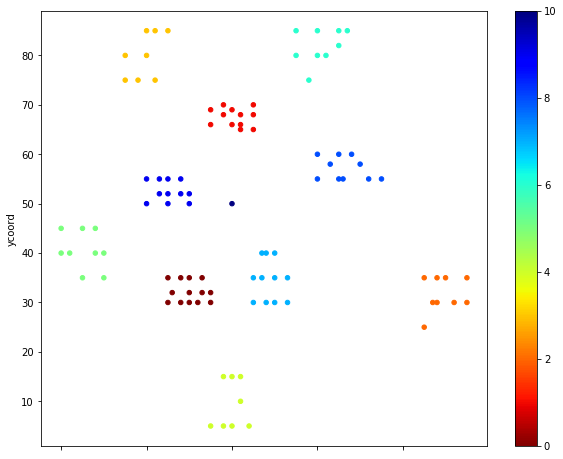


    Initial solution: 
        number of vehicles = 11
        cost = 974.1132163228089
        feasible = True
    
    Initial graph


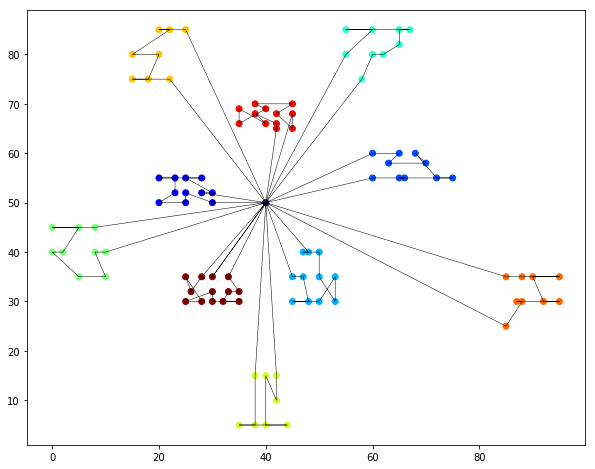

    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 879.2700077031416
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 894.9675133272069
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 894.9675133272069
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 883.0971633499687
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 887.4115615693463
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 5 iterations, current cost = 864.1739960324524
    Perturbing...
    Looking for feasible and better...
    Loc

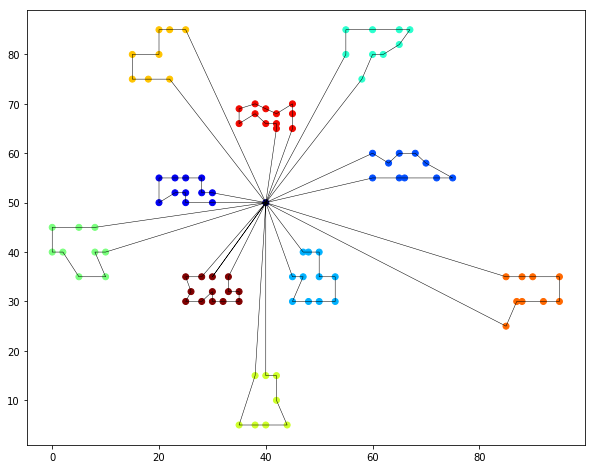

    Instance C203



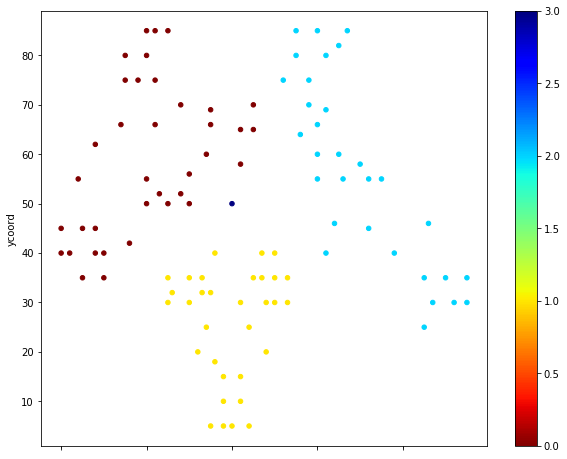


    Initial solution: 
        number of vehicles = 5
        cost = 1413.5828812355714
        feasible = True
    
    Initial graph


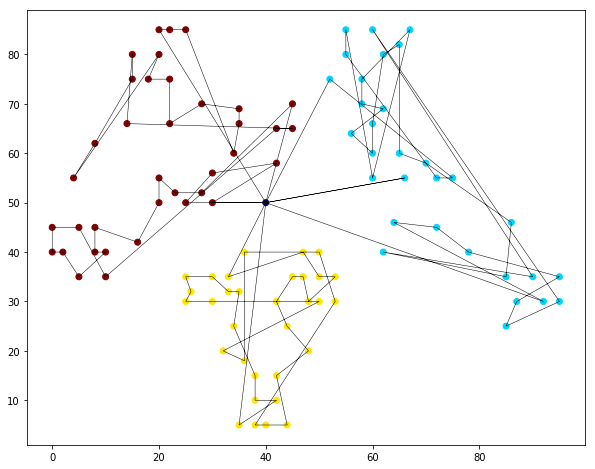

    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1161.5003967505088
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1035.1146095014
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1201.0409885588215
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1161.5003967505088
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1035.1146095014
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1035.1146095014
    Perturbing...
    Looking for feasible and better...
    Local 

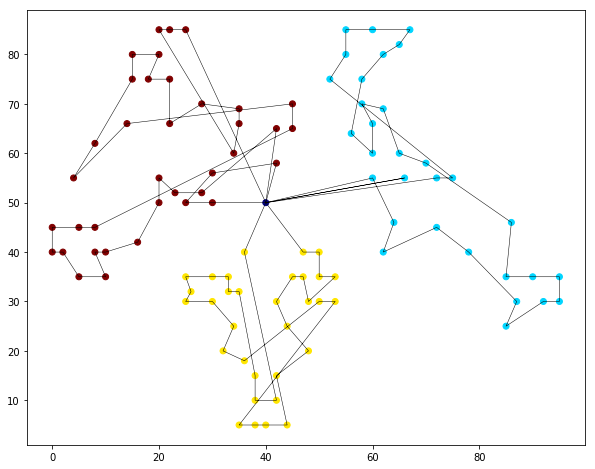

    Instance c2_4_9



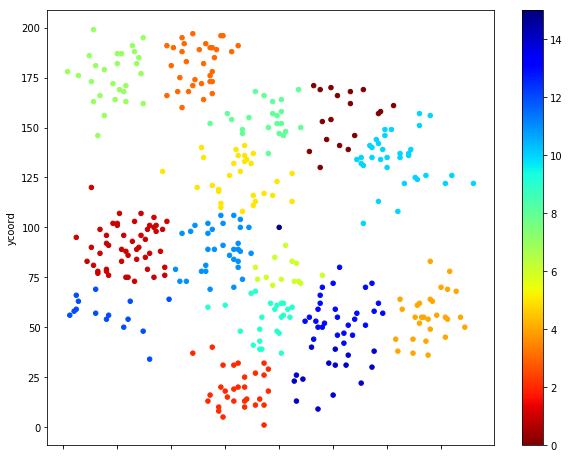


    Initial solution: 
        number of vehicles = 24
        cost = 8260.645645163118
        feasible = True
    
    Initial graph


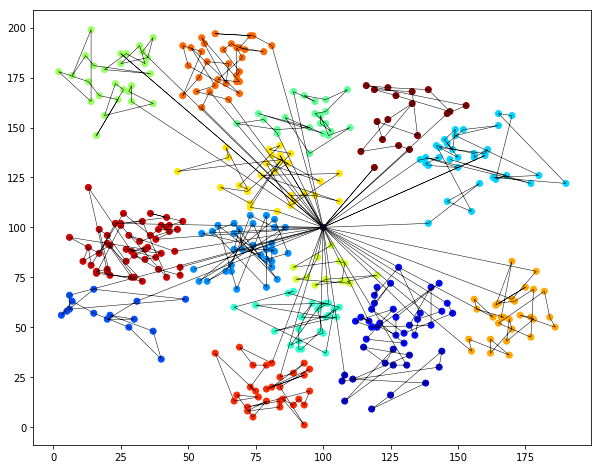

    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 6500.649002010233
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 6329.327551563028
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 6417.059519969579
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 5 iterations, current cost = 6289.027332474291
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 6500.649002010233
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 6451.642066741077
    Perturbing...
    Looking for feasible and better...
    Loc

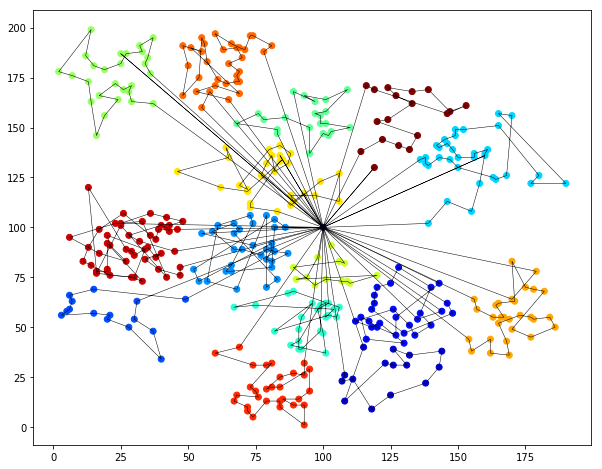

    Instance c2_6_6



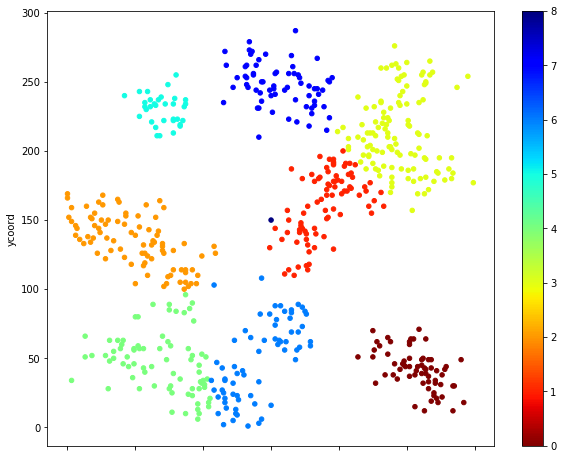


    Initial solution: 
        number of vehicles = 29
        cost = 20633.16496693193
        feasible = True
    
    Initial graph


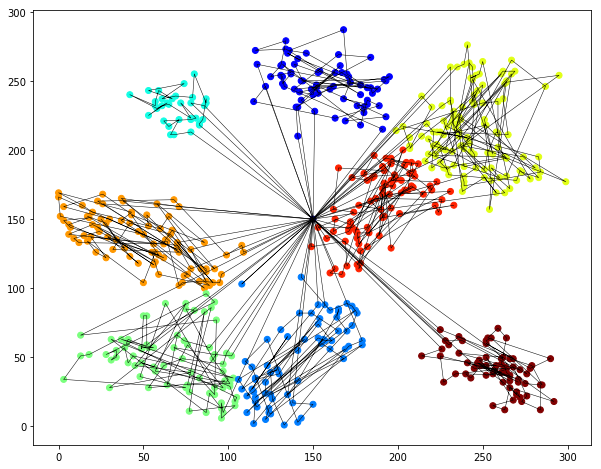

    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 17908.17286566323
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 17965.840168947376
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 18006.70365372259
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 17843.131764911814
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 17875.254683686555
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 18003.811309019955
    Perturbing...
    Looking for feasible and better...
   

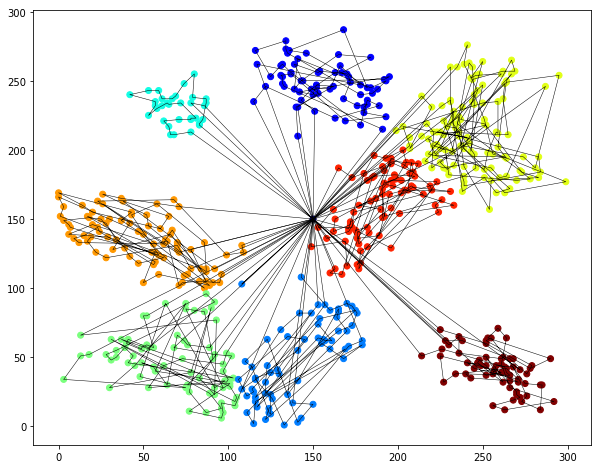

    Instance r1_4_6



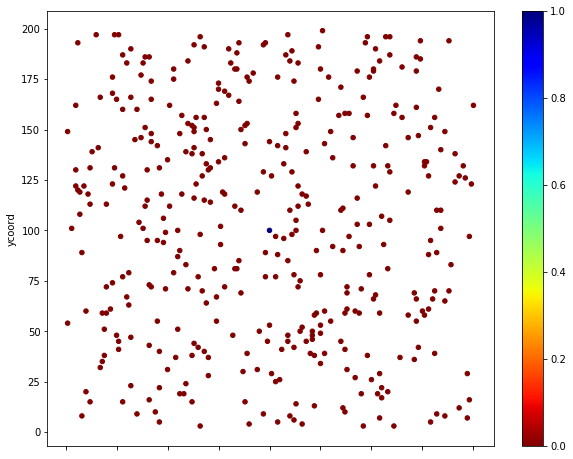


    Initial solution: 
        number of vehicles = 43
        cost = 16353.08326456129
        feasible = True
    
    Initial graph


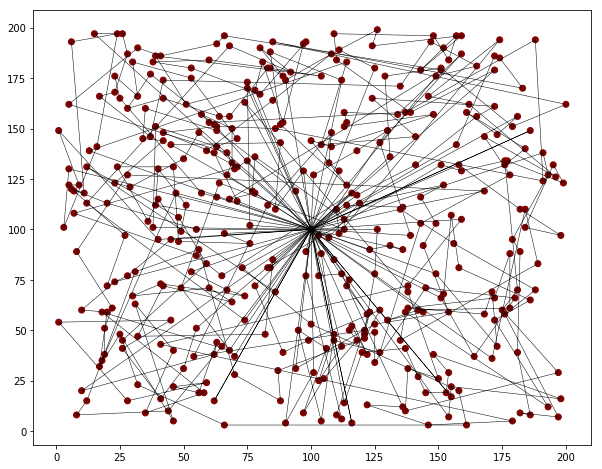

    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 16338.80410357757
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 16346.814157216386
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 16375.51719644164
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 16494.70727525474
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 16377.873725031117
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 5 iterations, current cost = 16233.23690871791
    Perturbing...
    Looking for feasible and better...
    L

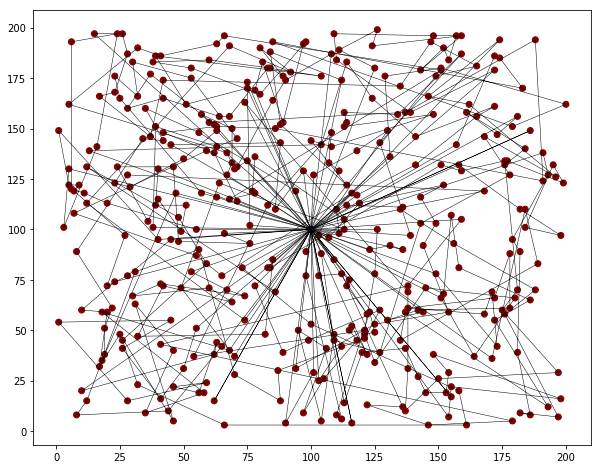

    Instance r1_6_8



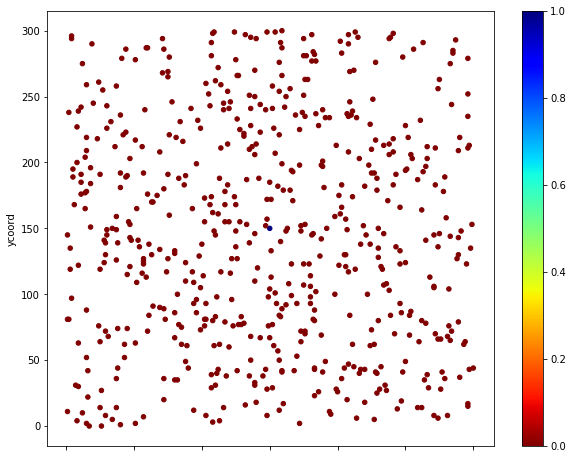


    Initial solution: 
        number of vehicles = 54
        cost = 26957.9319843782
        feasible = True
    
    Initial graph


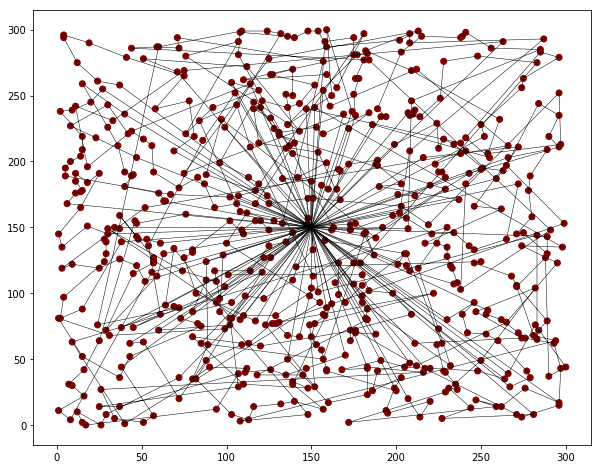

    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 5 iterations, current cost = 26442.998988743264
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 5 iterations, current cost = 26442.998988743264
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 26468.22223601426
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 26750.133080489497
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 8 iterations, current cost = 26442.21001926736
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 5 iterations, current cost = 26442.21001926736
    Perturbing...
    Looking for feasible and better...
    

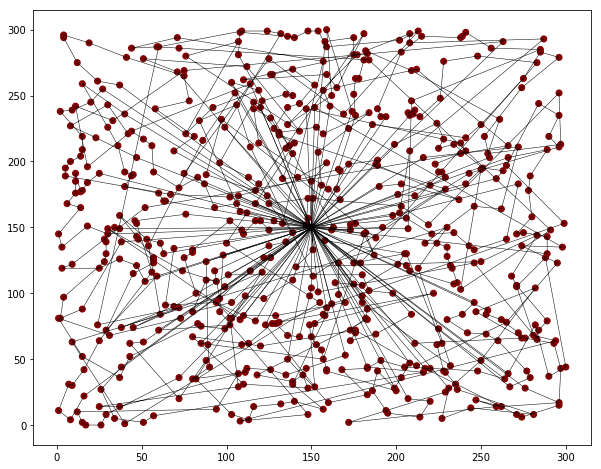

    Instance R202



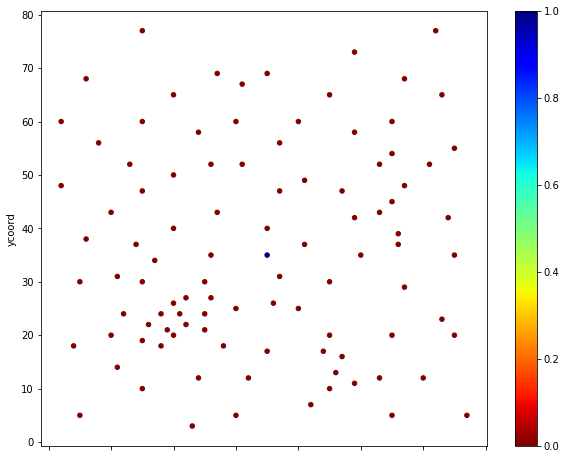


    Initial solution: 
        number of vehicles = 5
        cost = 2294.1236098716918
        feasible = True
    
    Initial graph


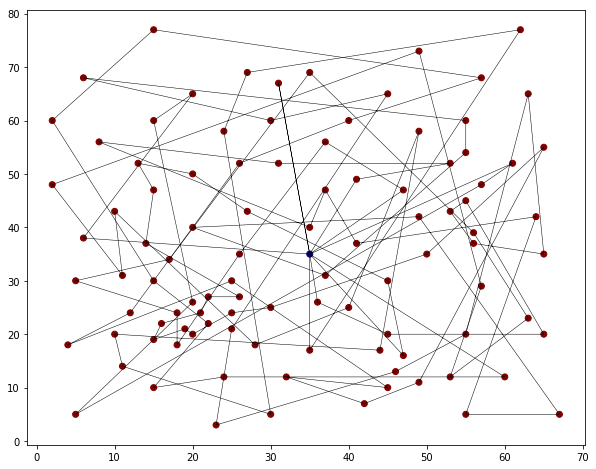

    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 2434.6885733111976
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 2441.6517254532355
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 2441.6517254532355
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 2434.6885733111976
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 2434.6885733111976
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 2373.673381868609
    Perturbing...
    Looking for feasible and better...
  

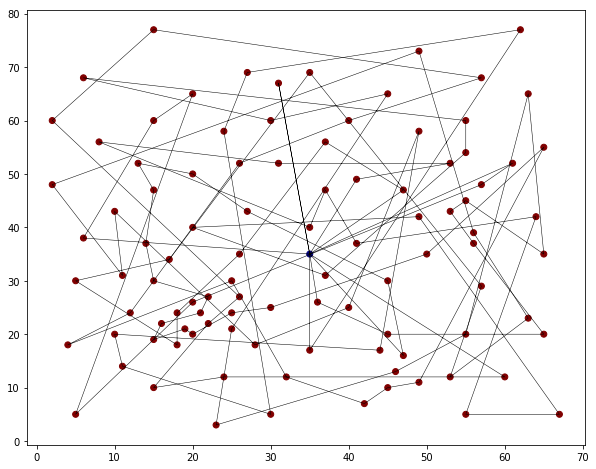

    Instance RC105



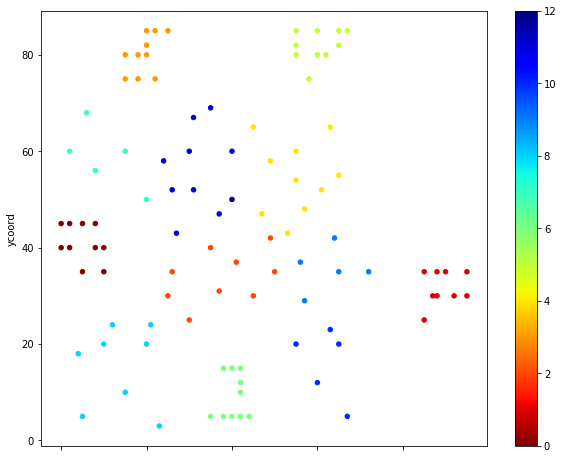


    Initial solution: 
        number of vehicles = 20
        cost = 2179.3915066259733
        feasible = True
    
    Initial graph


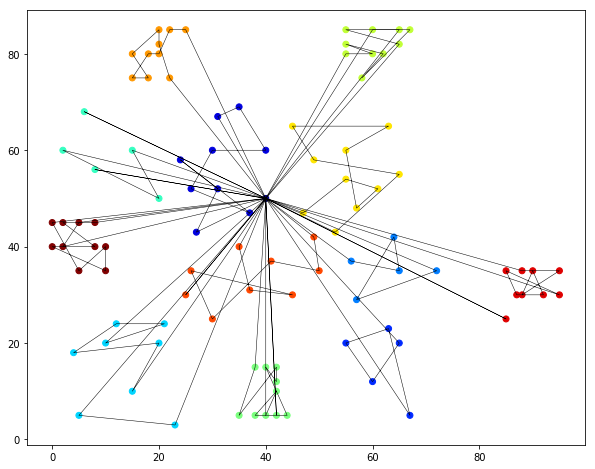

    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 2128.1627644096543
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 2143.9624794345914
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 2120.236543628159
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 2128.1627644096543
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 2120.236543628159
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 2127.219477496683
    Perturbing...
    Looking for feasible and better...
    

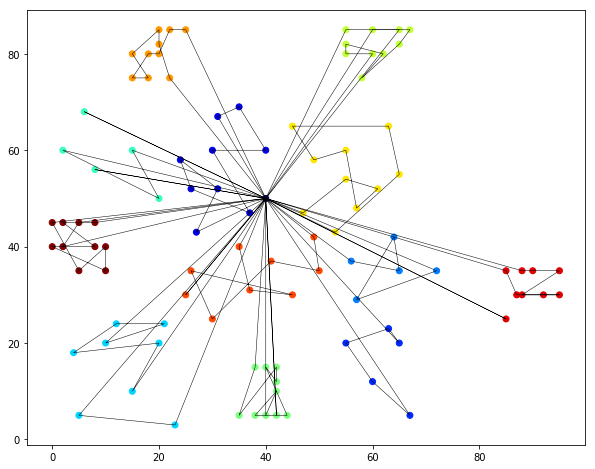

    Instance rc1_4_8



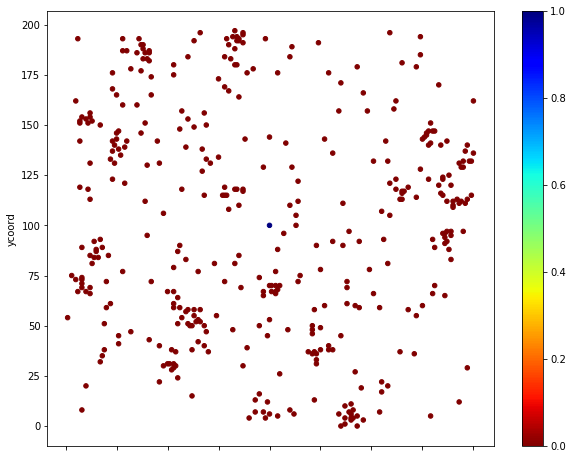


    Initial solution: 
        number of vehicles = 39
        cost = 14558.692345742962
        feasible = True
    
    Initial graph


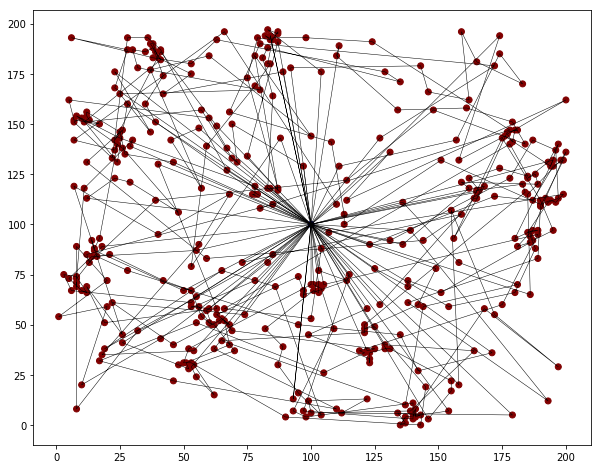

    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 14313.237550314048
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 14290.169883710134
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 14237.025463401817
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 14386.263280151854
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 14242.002854080702
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 14268.211686078781
    Perturbing...
    Looking for feasible and better...
 

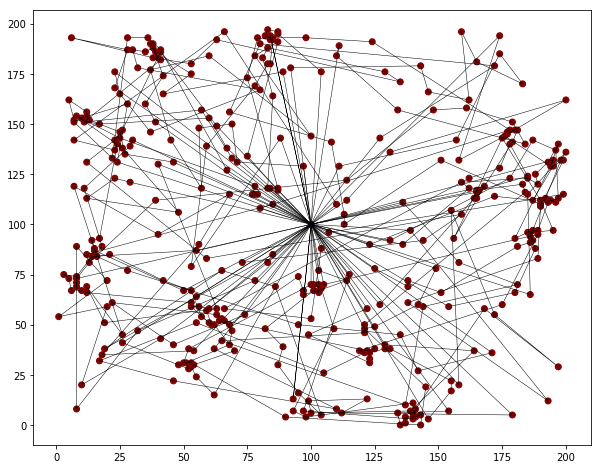

    Instance RC207



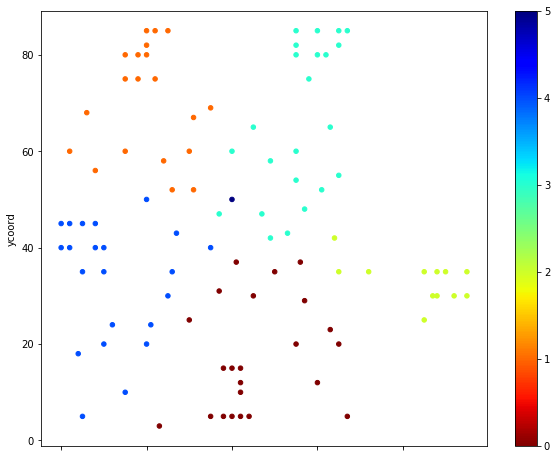


    Initial solution: 
        number of vehicles = 5
        cost = 1798.0596281940327
        feasible = True
    
    Initial graph


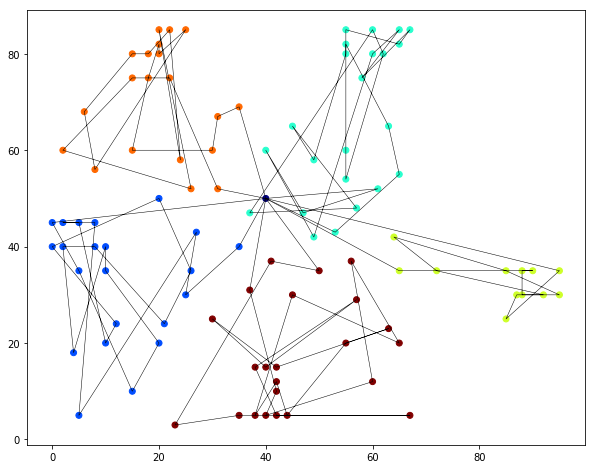

    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1376.626184269722
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1376.626184269722
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 5 iterations, current cost = 1279.1475853696602
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1441.2514388232562
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1421.7802520165358
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1441.2514388232562
    Perturbing...
    Looking for feasible and better...
   

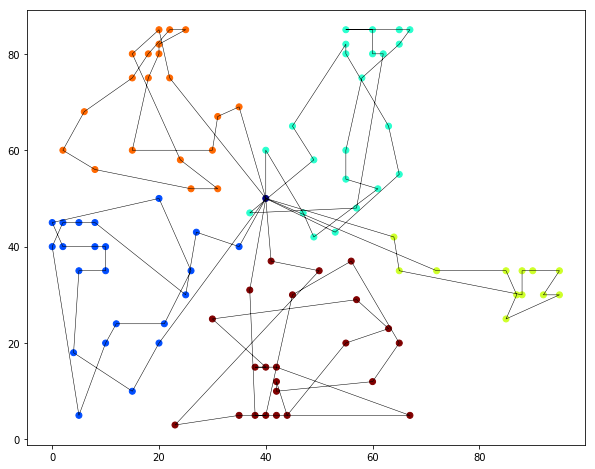

In [296]:
import glob
import scipy
import matplotlib.pyplot as plt
import joblib
import numpy as np
import VRPSolver
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')
instances = glob.glob('./instances/*.txt')
cluster_size = {'C108': 10, 'C203':3, 'C249': 15, 'R168': 1, 'R146': 1, 'C266': 8,
                'R202': 1, 'RC105': 12, 'RC148': 1, 'RC207': 5}

def save_solution(sol):
    with open('./sol/{}.sol'.format(instance.split('.')[-2].split('\\')[-1]), 'w') as f:
        def r_str(route):
            r_str = ' '.join(['{} {}'.format(client, slv.arrival[client]) for client in route[:-1]])
            i = route[-2]
            return r_str + ' 0 {}'.format(slv.arrival[i] + slv.service[i] + slv.dist(i, 0))
        print('\n'.join([r_str(route) for route in sol]), file=f)

def plot_solution(sol):
    plt.figure(figsize=(10,8))
    plt.scatter(slv.df.xcoord, slv.df.ycoord, c=slv.df.cluster, cmap='jet_r')
    for route in sol:
        plt.plot(slv.df.xcoord[route], slv.df.ycoord[route], linewidth=0.5, color='black')
    plt.show()


for instance in instances[:]:
    name = instance.split('.')[-2].split('\\')[-1]
    slv = VRPSolver.VRPSolver(instance, cluster_size[name], 8)
    print("    Instance {}".format(slv.name))
    slv.df.plot.scatter(0, 1, c=slv.df.cluster, colormap='jet_r', figsize=(10,8))
    plt.show()
    
    n_vehicles, initial_solution, cost = slv.get_initial_solution(0)
    print(
    """
    Initial solution: 
        number of vehicles = {}
        cost = {}
        feasible = {}
    """.format(n_vehicles, cost, slv.is_solution_feasible(initial_solution))
    )
    
    print('    Initial graph')
    plot_solution(initial_solution)

    with joblib.Parallel(1) as parallel:
        solution = IteratedLocalSearch(initial_solution, parallel, slv)
    
    save_solution(solution)
    
    print('    Graph after local search')
    plot_solution(solution)

In [287]:
import importlib
importlib.reload(VRPSolver)

<module 'VRPSolver' from 'C:\\Users\\Saldern\\jupyter\\vrp\\VRPSolver.py'>

In [2]:
import glob
import scipy
import matplotlib.pyplot as plt
import joblib
import numpy as np
import VRPSolver
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')
instances = glob.glob('./instances/*.txt')
cluster_size = {'C108': 10, 'C203':3, 'C249': 15, 'R168': 10, 'R146': 10, 'C266': 8,
                'R202': 10, 'RC105': 12, 'RC148': 10, 'RC207': 5}

def save_solution(sol):
    with open('./sol/{}.sol'.format(instance.split('.')[-2].split('\\')[-1]), 'w') as f:
        def r_str(route):
            r_str = ' '.join(['{} {}'.format(client, slv.arrival[client]) for client in route[:-1]])
            i = route[-2]
            return r_str + ' 0 {}'.format(slv.arrival[i] + slv.service[i] + slv.dist(i, 0))
        print('\n'.join([r_str(route) for route in sol]), file=f)

def plot_solution(sol):
    plt.figure(figsize=(10,8))
    plt.scatter(slv.df.xcoord, slv.df.ycoord, c=slv.df.cluster, cmap='jet_r')
    for route in sol:
        plt.plot(slv.df.xcoord[route], slv.df.ycoord[route], linewidth=0.5, color='black')
    plt.show()

instance = instances[0]

    Instance C108



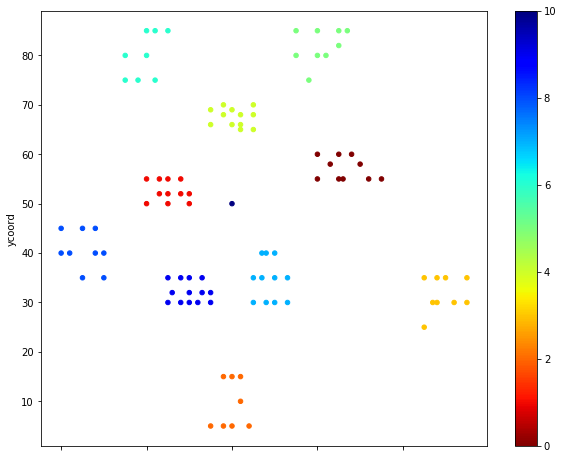


Initial solution: 
    number of vehicles = 11
    cost = 974.1132163228089
    feasible = True

    Initial graph


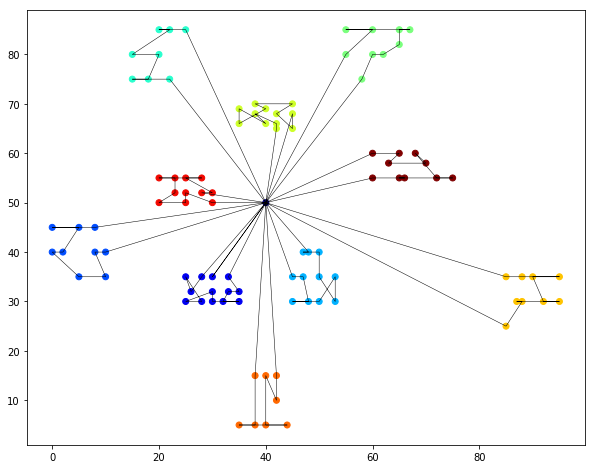

    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 894.9675133272069
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 5 iterations, current cost = 864.1739960324524
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 5 iterations, current cost = 864.1739960324524
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 885.6736296907452
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 5 iterations, current cost = 864.1739960324524
    Perturbing...
    Looking for feasible and better...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 887.4115615693463
    Perturbing...
    Looking for feasible and better...
    Loc

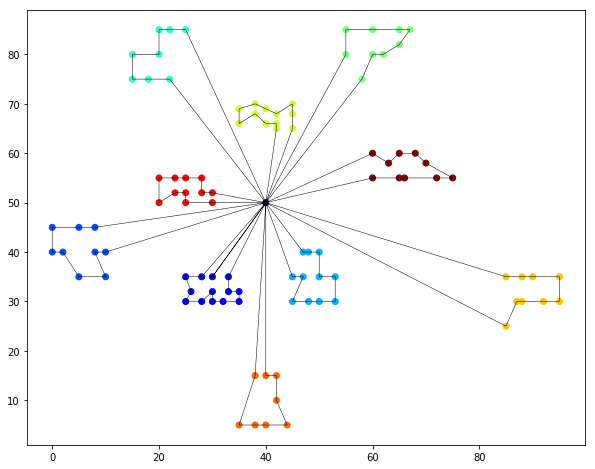

In [4]:
name = instance.split('.')[-2].split('\\')[-1]
slv = VRPSolver.VRPSolver(instance, cluster_size[name], 8)
print("    Instance {}".format(slv.name))
slv.df.plot.scatter(0, 1, c=slv.df.cluster, colormap='jet_r', figsize=(10,8))
plt.show()

n_vehicles, initial_solution, cost = slv.get_initial_solution(0)
print(
"""
Initial solution: 
    number of vehicles = {}
    cost = {}
    feasible = {}
""".format(n_vehicles, cost, slv.is_solution_feasible(initial_solution))
)

print('    Initial graph')
plot_solution(initial_solution)

with joblib.Parallel(1) as parallel:
    solution = IteratedLocalSearch(initial_solution, parallel, slv)

def unload_and_move(i, j, arrival):
    return arrival[i] + slv.service[i] + slv.dist(i, j)

answer = ''
arrival = np.zeros(slv.df.shape[0])
for route in solution[:]:
    for i, client in enumerate(route[:-2]):
        next_client = route[i+1]
        arrival[next_client] = np.max([unload_and_move(client, next_client, arrival), slv.opened[next_client]])
    route_arrivals = arrival[route]
    route_arrivals[-1] = unload_and_move(route[-2], 0, arrival)
    answer = answer + ' '.join(['{} {}'.format(c, arr) for c, arr in zip(route, route_arrivals)]) + '\n'

with open('./sol/{}.sol'.format(instance.split('.')[-2].split('\\')[-1]), 'w') as f:
    print(answer, file=f)
    
print('    Graph after local search')
plot_solution(solution)

In [5]:
def save_solution(sol):
    with open('./sol/{}.sol'.format(instance.split('.')[-2].split('\\')[-1]), 'w') as f:
        def r_str(route):
            r_str = ' '.join(['{} {}'.format(client, slv.arrival[client]) for client in route[:-1]])
            i = route[-2]
            return r_str + ' 0 {}'.format(slv.arrival[i] + slv.service[i] + slv.dist(i, 0))
        print('\n'.join([r_str(route) for route in sol]))
        
save_solution(solution)

0 0.0 5 15.132745950421556 3 106.13274595042155 7 198.13274595042157 8 290.9611730751678 10 384.5667243506318 11 477.5667243506318 9 570.7290020108002 6 662.9650699883 4 755.2011379657998 2 848.8066892412638 1 940.8066892412638 75 1033.806689241264 0 1139.6180775421058
0 0.0 13 30.805843601498726 17 124.80584360149872 18 217.80584360149874 19 312.80584360149874 15 407.80584360149874 16 502.80584360149874 14 594.8058436014987 12 687.8058436014987 0 815.8847091308182
0 0.0 20 10.0 24 105.0 25 197.0 27 289.0 29 382.605551275464 30 477.605551275464 28 570.605551275464 26 662.605551275464 23 755.605551275464 22 848.605551275464 21 940.605551275464 0 1040.8035903026496
0 0.0 32 31.622776601683793 33 123.6227766016838 31 219.0079414088183 35 314.0079414088183 37 409.8388933036636 38 501.8388933036636 39 596.8388933036636 36 691.8388933036636 34 784.8388933036636 0 907.2271627850669
0 0.0 43 16.55294535724685 42 109.55294535724684 41 201.55294535724684 40 293.5529453572468 44 386.5529453572468

    Instance C108



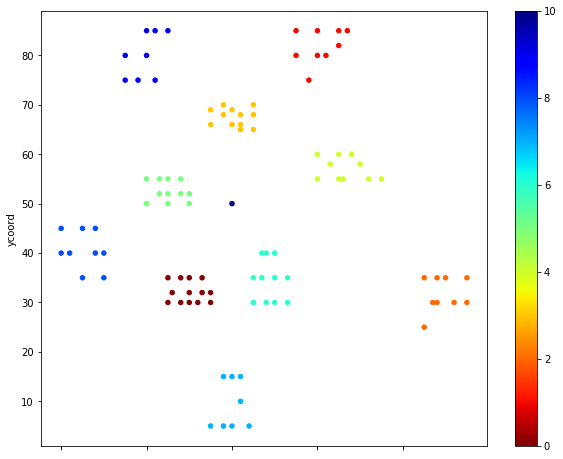


    Initial solution: 
        number of vehicles = 11
        cost = 974.1132163228089
        feasible = True
    
    Initial graph


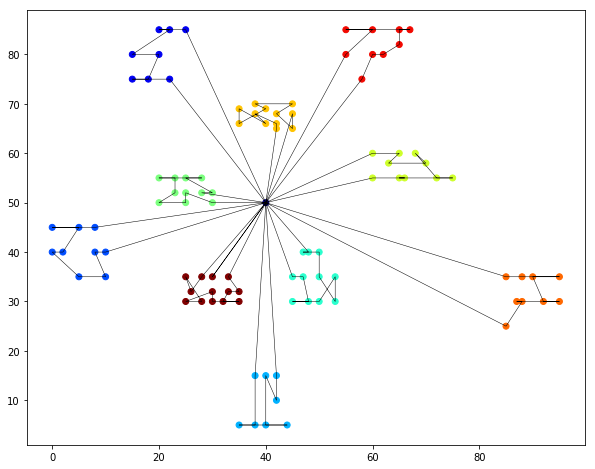

    Graph after local search


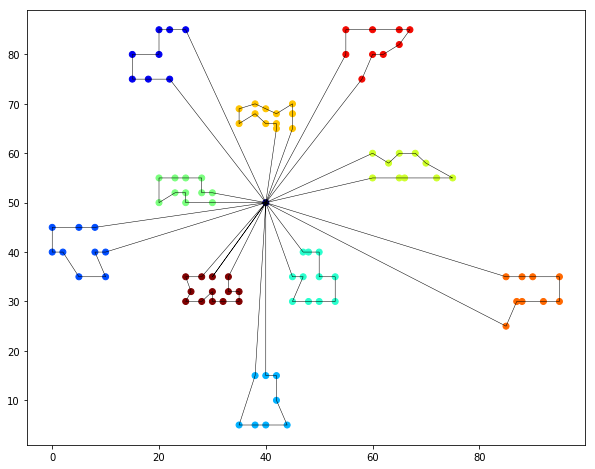

    Instance C203



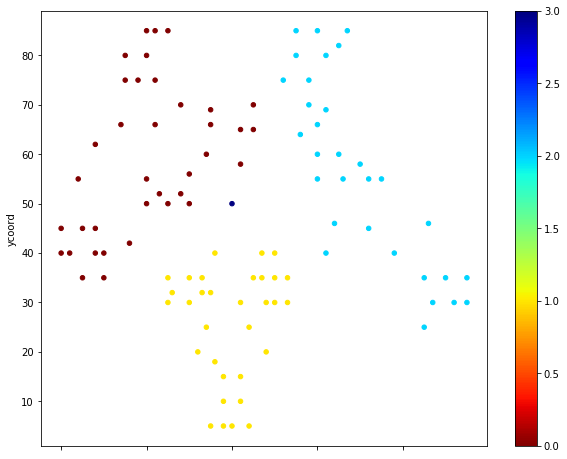


    Initial solution: 
        number of vehicles = 5
        cost = 1413.5828812355714
        feasible = True
    
    Initial graph


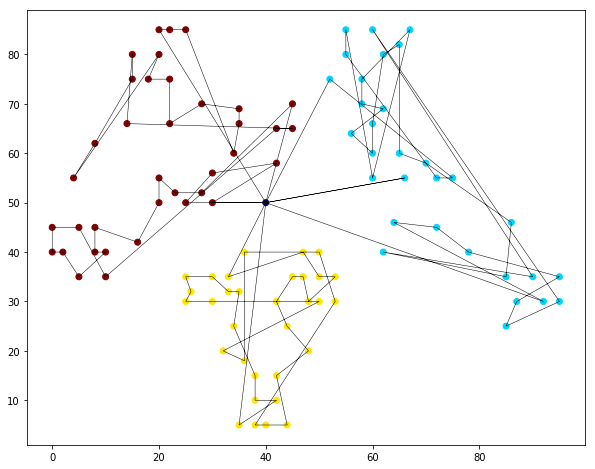

    Graph after local search


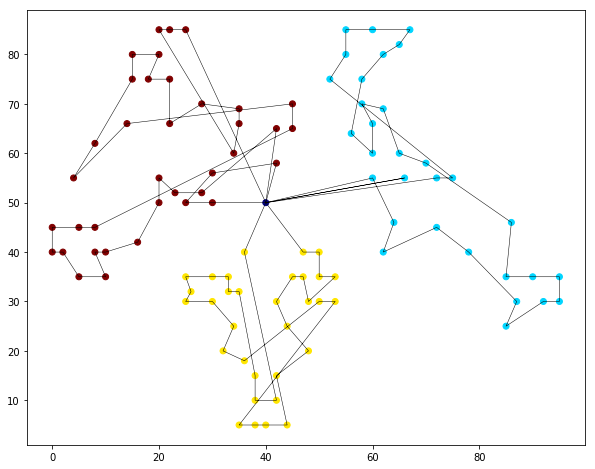

    Instance c2_4_9



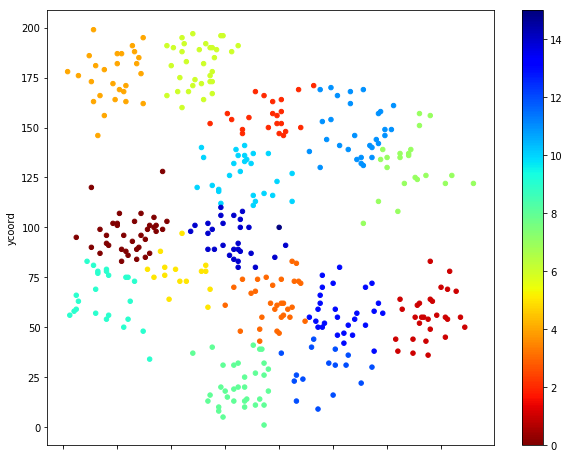


    Initial solution: 
        number of vehicles = 25
        cost = 8472.77582511708
        feasible = True
    
    Initial graph


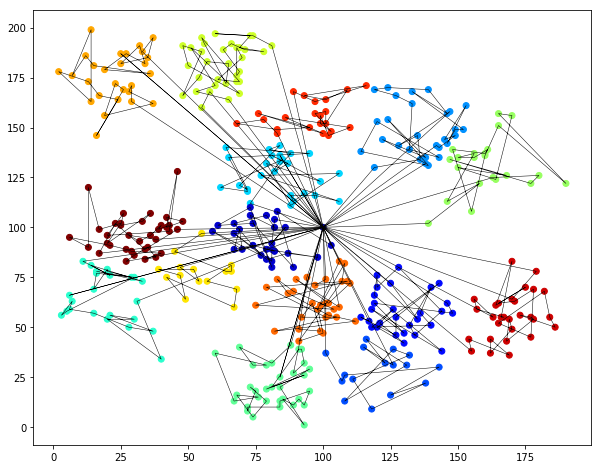

    Graph after local search


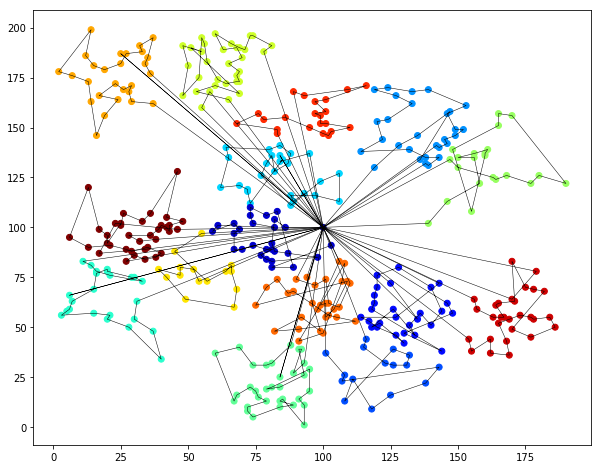

    Instance c2_6_6



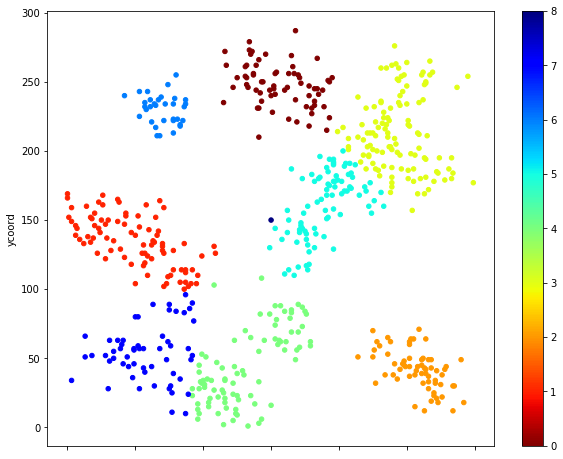


    Initial solution: 
        number of vehicles = 28
        cost = 20368.88152050826
        feasible = True
    
    Initial graph


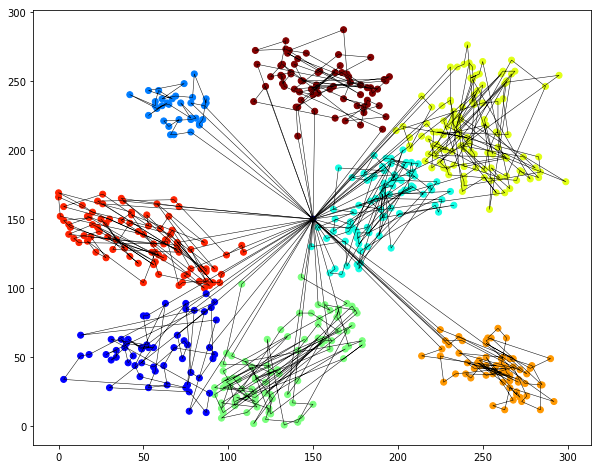

    Graph after local search


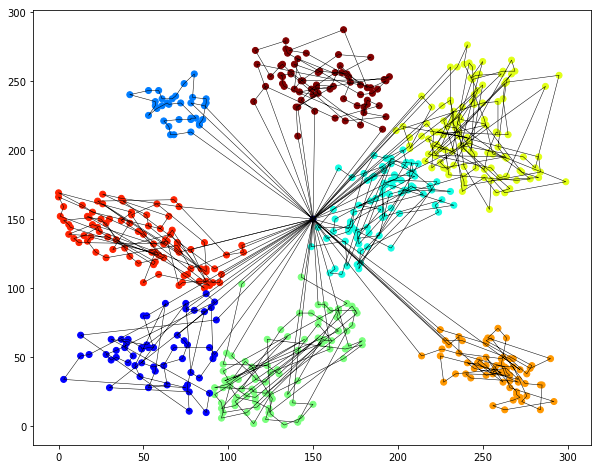

    Instance r1_4_6



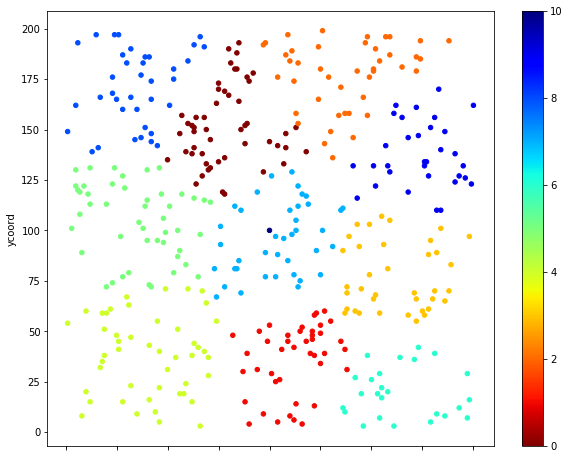


    Initial solution: 
        number of vehicles = 48
        cost = 14872.079976717658
        feasible = True
    
    Initial graph


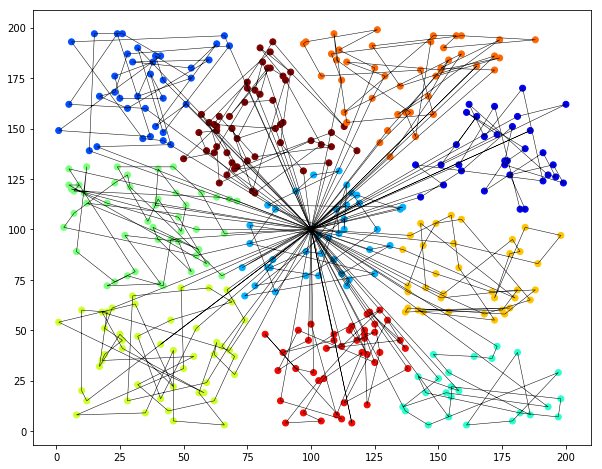

    Graph after local search


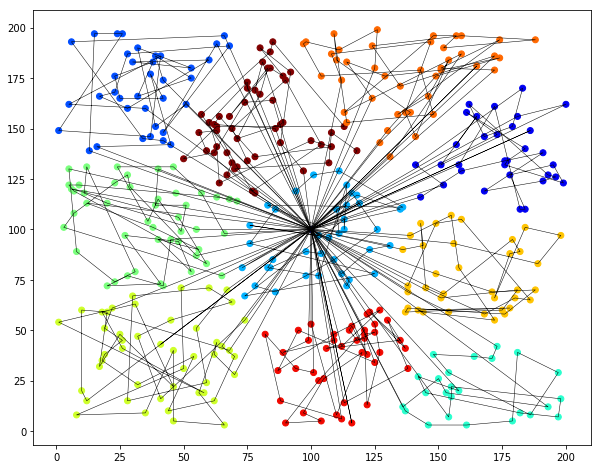

    Instance r1_6_8



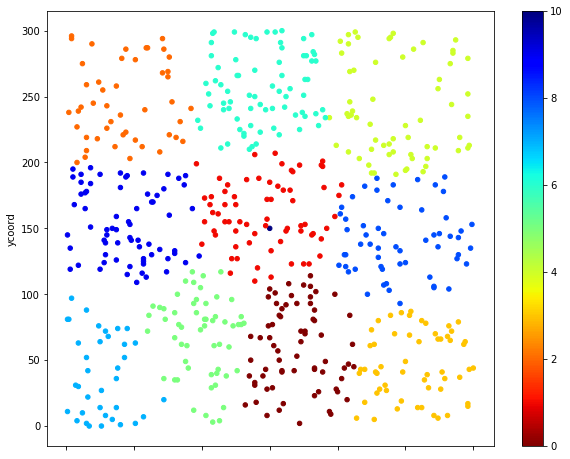


    Initial solution: 
        number of vehicles = 59
        cost = 23451.068070312413
        feasible = True
    
    Initial graph


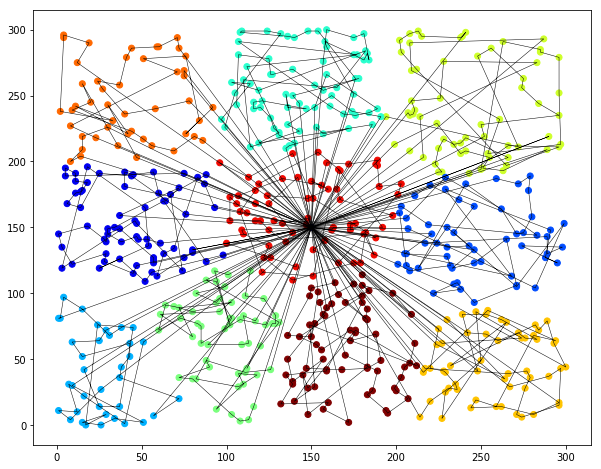

    Graph after local search


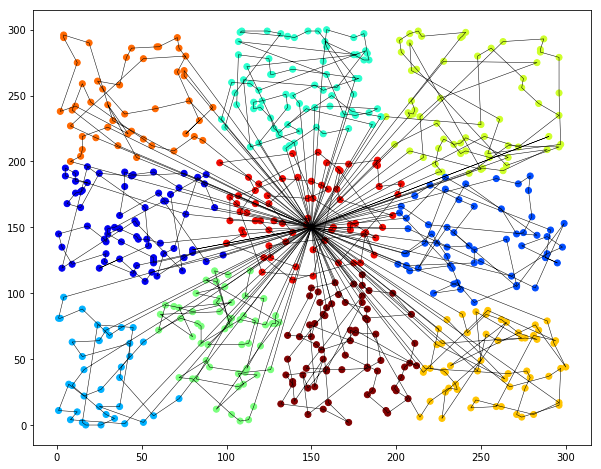

    Instance R202



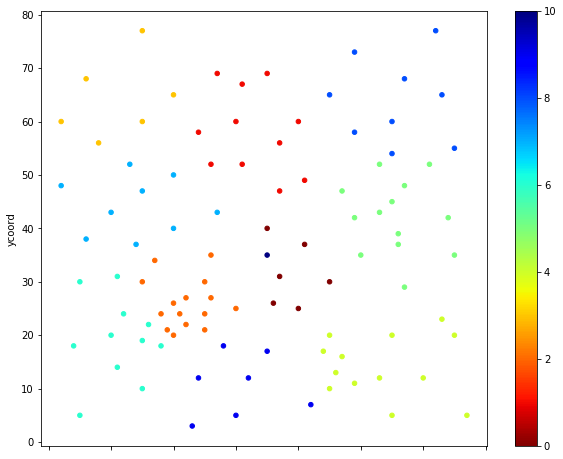


    Initial solution: 
        number of vehicles = 10
        cost = 1437.2210926175562
        feasible = True
    
    Initial graph


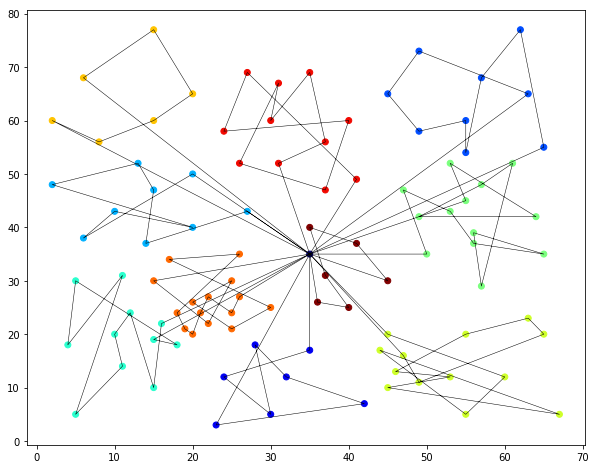

    Graph after local search


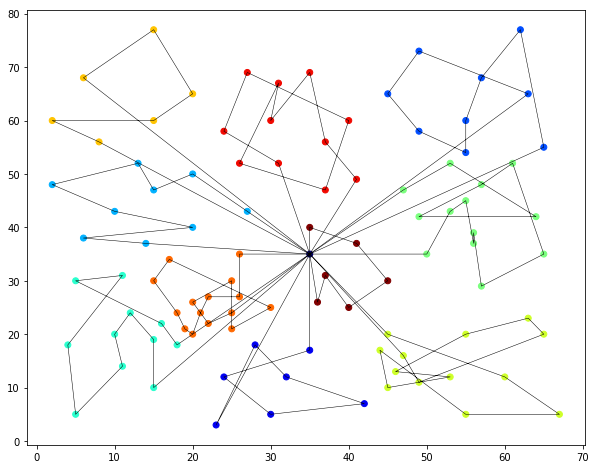

    Instance RC105



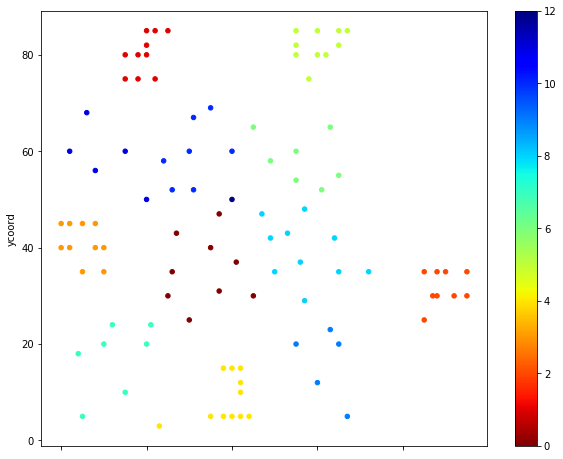


    Initial solution: 
        number of vehicles = 21
        cost = 2222.4708099065288
        feasible = True
    
    Initial graph


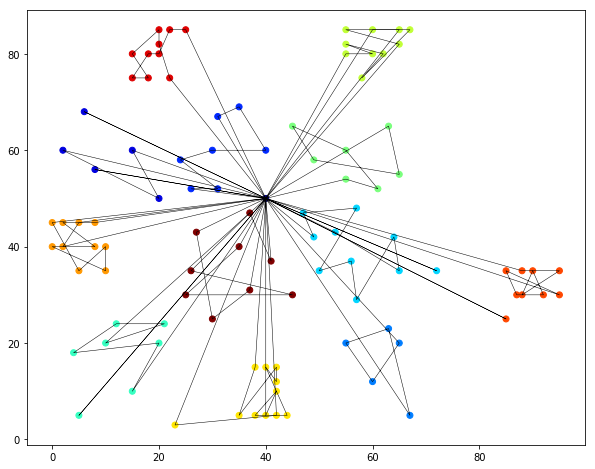

    Graph after local search


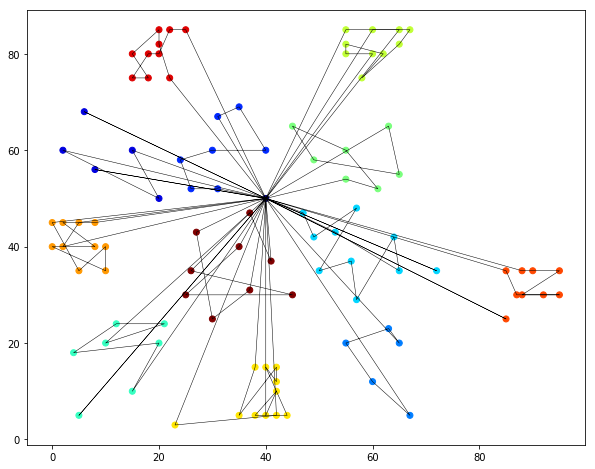

    Instance rc1_4_8



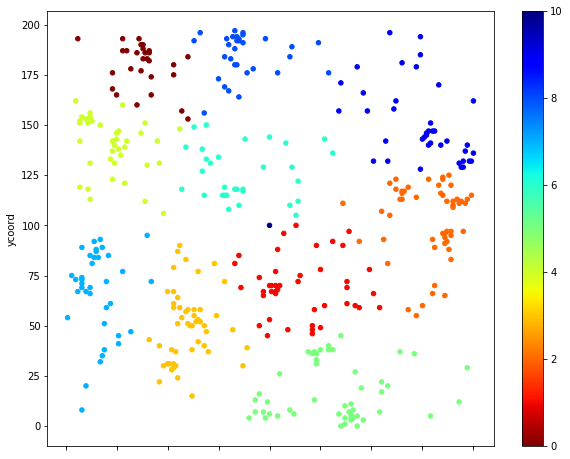


    Initial solution: 
        number of vehicles = 41
        cost = 12877.75647902359
        feasible = True
    
    Initial graph


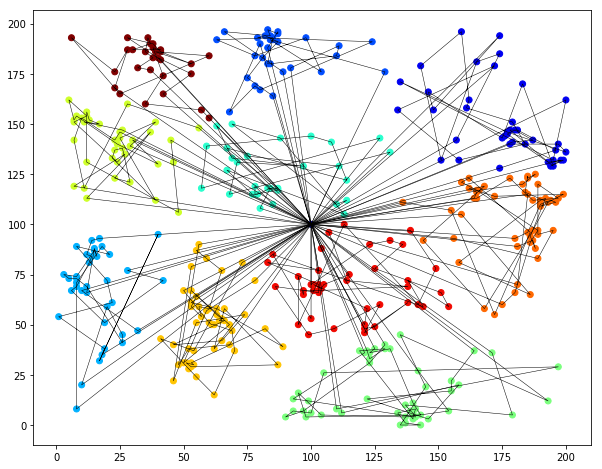

    Graph after local search


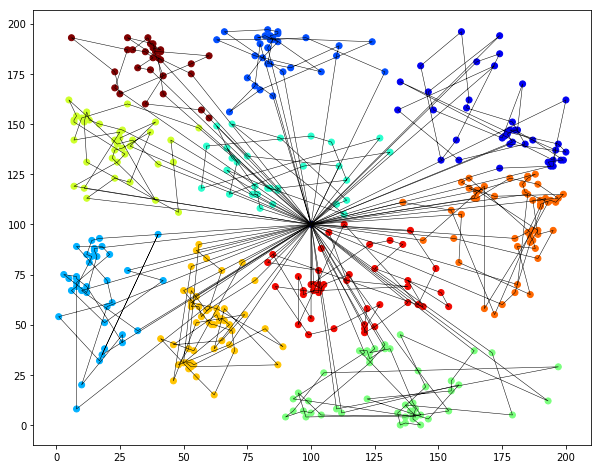

    Instance RC207



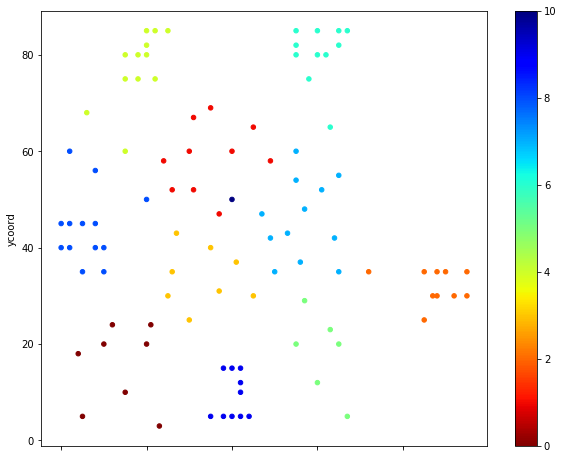


    Initial solution: 
        number of vehicles = 10
        cost = 1629.9850691001784
        feasible = True
    
    Initial graph


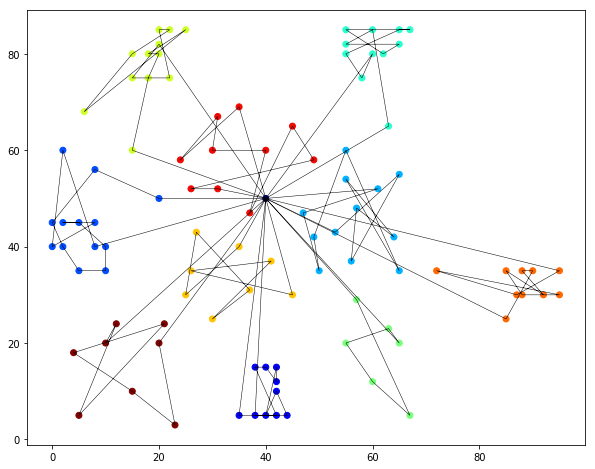

    Graph after local search


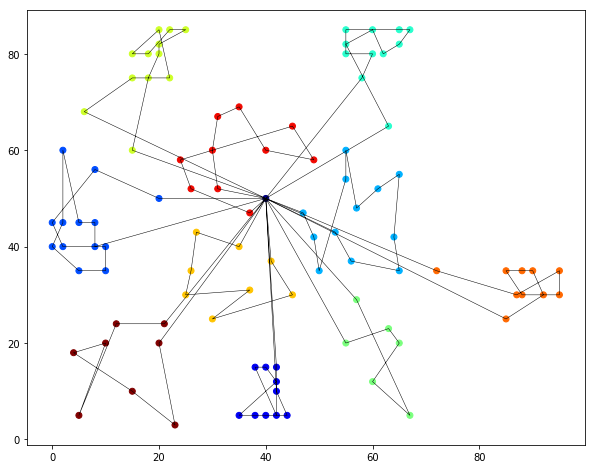

In [34]:
import glob
import scipy
import matplotlib.pyplot as plt
import joblib
import numpy as np
import VRPSolver
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')
instances = glob.glob('./instances/*.txt')
cluster_size = {'C108': 10, 'C203':3, 'C249': 15, 'R168': 10, 'R146': 10, 'C266': 8,
                'R202': 10, 'RC105': 12, 'RC148': 10, 'RC207': 10}

def save_solution(sol):
    with open('./sol/{}.sol'.format(instance.split('.')[-2].split('\\')[-1]), 'w') as f:
        def r_str(route):
            r_str = ' '.join(['{} {}'.format(client, slv.arrival[client]) for client in route[:-1]])
            i = route[-2]
            return r_str + ' 0 {}'.format(slv.arrival[i] + slv.service[i] + slv.dist(i, 0))
        print('\n'.join([r_str(route) for route in sol]), file=f)

def plot_solution(sol):
    plt.figure(figsize=(10,8))
    plt.scatter(slv.df.xcoord, slv.df.ycoord, c=slv.df.cluster, cmap='jet_r')
    for route in sol:
        plt.plot(slv.df.xcoord[route], slv.df.ycoord[route], linewidth=0.5, color='black')
    plt.show()


for instance in instances[:]:
    name = instance.split('.')[-2].split('\\')[-1]
    slv = VRPSolver.VRPSolver(instance, cluster_size[name], 8)
    print("    Instance {}".format(slv.name))
    slv.df.plot.scatter(0, 1, c=slv.df.cluster, colormap='jet_r', figsize=(10,8))
    plt.show()
    
    n_vehicles, initial_solution, cost = slv.get_initial_solution(0)
    print(
    """
    Initial solution: 
        number of vehicles = {}
        cost = {}
        feasible = {}
    """.format(n_vehicles, cost, slv.is_solution_feasible(initial_solution))
    )
    
    print('    Initial graph')
    plot_solution(initial_solution)

    with joblib.Parallel(1) as parallel:
        solution = IteratedLocalSearch(initial_solution, parallel, slv)
    
    def unload_and_move(i, j, arrival):
        return arrival[i] + slv.service[i] + slv.dist(i, j)

    answer = ''
    arrival = np.zeros(slv.df.shape[0])
    for route in solution[:]:
        for i, client in enumerate(route[:-2]):
            next_client = route[i+1]
            arrival[next_client] = np.max([unload_and_move(client, next_client, arrival), slv.opened[next_client]])
        route_arrivals = arrival[route]
        route_arrivals[-1] = unload_and_move(route[-2], 0, arrival)
        answer = answer + ' '.join(['{} {}'.format(c, arr) for c, arr in zip(route, route_arrivals)]) + '\n'

    with open('./sol/{}.sol'.format(instance.split('.')[-2].split('\\')[-1]), 'w') as f:
        print(answer, file=f)
    
    print('    Graph after local search')
    plot_solution(solution)

In [30]:
def unload_and_move(i, j, arrival):
    return arrival[i] + slv.service[i] + slv.dist(i, j)

answer = ''
arrival = np.zeros(slv.df.shape[0])
for route in solution[:]:
    for i, client in enumerate(route[:-2]):
        next_client = route[i+1]
        arrival[next_client] = np.max([unload_and_move(client, next_client, arrival), slv.opened[next_client]])
    route_arrivals = arrival[route]
    route_arrivals[-1] = unload_and_move(route[-2], 0, arrival)
    answer = answer + ' '.join(['{} {}'.format(c, arr) for c, arr in zip(route, route_arrivals)]) + '\n'

In [31]:
print(answer)

0 0.0 5 15.132745950421556 3 106.13274595042155 7 198.13274595042157 8 290.9611730751678 10 384.5667243506318 11 477.5667243506318 9 570.7290020108002 6 662.9650699883 4 755.2011379657998 2 848.8066892412638 1 940.8066892412638 75 1033.806689241264 0 1139.6180775421058
0 0.0 13 30.805843601498726 17 124.80584360149872 18 217.80584360149874 19 312.80584360149874 15 407.80584360149874 16 502.80584360149874 14 594.8058436014987 12 687.8058436014987 0 815.8847091308182
0 0.0 20 10.0 24 105.0 25 197.0 27 289.0 29 382.605551275464 30 477.605551275464 28 570.605551275464 26 662.605551275464 23 755.605551275464 22 848.605551275464 21 940.605551275464 0 1040.8035903026496
0 0.0 32 31.622776601683793 33 123.6227766016838 31 219.0079414088183 35 314.0079414088183 37 409.8388933036636 38 501.8388933036636 39 596.8388933036636 36 691.8388933036636 34 784.8388933036636 0 907.2271627850669
0 0.0 43 16.55294535724685 42 109.55294535724684 41 201.55294535724684 40 293.5529453572468 44 386.5529453572468

In [32]:
for route in solution:
    print(route)
    print(arrival[route])

[ 0  5  3  7  8 10 11  9  6  4  2  1 75  0]
[   0.           15.13274595  106.13274595  198.13274595  290.96117308
  384.56672435  477.56672435  570.72900201  662.96506999  755.20113797
  848.80668924  940.80668924 1033.80668924    0.        ]
[ 0 13 17 18 19 15 16 14 12  0]
[  0.         30.8058436 124.8058436 217.8058436 312.8058436 407.8058436
 502.8058436 594.8058436 687.8058436   0.       ]
[ 0 20 24 25 27 29 30 28 26 23 22 21  0]
[  0.          10.         105.         197.         289.
 382.60555128 477.60555128 570.60555128 662.60555128 755.60555128
 848.60555128 940.60555128   0.        ]
[ 0 32 33 31 35 37 38 39 36 34  0]
[  0.          31.6227766  123.6227766  219.00794141 314.00794141
 409.8388933  501.8388933  596.8388933  691.8388933  784.8388933
   0.        ]
[ 0 43 42 41 40 44 45 46 48 51 50 52 49  0]
[   0.           16.55294536  109.55294536  201.55294536  293.55294536
  386.55294536  478.55294536  570.55294536  663.38137248  756.38137248
  848.61744046  941.77971812

In [17]:
arrival

array([   0.        ,  940.80668924,  848.80668924,  106.13274595,
        755.20113797,   15.13274595,  662.96506999,  198.13274595,
        290.96117308,  570.72900201,  384.56672435,  477.56672435,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.     